In [1]:
# Example
F = 45 
C = (F - 32) * 5/9

# Print answer
print("The temperature is:", round(C, 2), "°C")

The temperature is: 7.22 °C


# Weather data

In this example we will read weather data for the Garden City station of the Kansas Mesonet, perform simple computations, and create some figures. The dataset is in an Excel file with two sheets (one for the data and the other for the metadata). In this example we will read the first sheet with the numerical data. The example assumes that the Jupyter Lab notebook (this file) and the dataset are located in the same directory.

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Read data from Excel file
df = pd.read_excel('data/garden_city_weather_ks_mesonet.xlsx', 
                   sheet_name='data', 
                   parse_dates=['timestamp'])

# Display a few rows
df.head(5)


,timestamp,rainfall,eto_grass,eto_alfalfa,tmax,tmin,srad
0,2024-04-01,0.0,2.87,4.14,17.7,4.0,12.9
1,2024-04-02,0.0,4.22,6.04,17.8,3.4,24.9
2,2024-04-03,0.0,3.85,5.07,20.3,-0.5,25.6
3,2024-04-04,0.0,4.38,5.88,24.3,0.8,26.0
4,2024-04-05,0.0,6.60,9.95,29.8,5.4,21.5


In [4]:
# Compute average temperature
df['tavg'] = (df['tmin'] + df['tmax'])/2

# Display a few rows
df.head(5)

,timestamp,rainfall,eto_grass,eto_alfalfa,tmax,tmin,srad,tavg
0,2024-04-01,0.0,2.87,4.14,17.7,4.0,12.9,10.85
1,2024-04-02,0.0,4.22,6.04,17.8,3.4,24.9,10.60
2,2024-04-03,0.0,3.85,5.07,20.3,-0.5,25.6,9.90
3,2024-04-04,0.0,4.38,5.88,24.3,0.8,26.0,12.55
4,2024-04-05,0.0,6.60,9.95,29.8,5.4,21.5,17.60


In [7]:
# Find and print total precipitation
P_total = df['rainfall'].sum().round(2)
print(f'Total precipitation in 2024 was {P_total} mm')


Total precipitation in 2024 was 320.03 mm


In [8]:
# Find value and time of minimum air temperature. Print value and timestamp.
tmin_idx = df['tmin'].argmin()
tmin_value = df.loc[tmin_idx, 'tmin']
tmin_timestamp = df.loc[tmin_idx, 'timestamp']
print(f'The lowest air temperature was {tmin_value} on {tmin_timestamp}')


The lowest air temperature was -3.4 on 2024-04-08 00:00:00


### Compute growing degree days

In [9]:
# Define cardinal temperature
T_base = 8 # Celsius

# Compute growing degree days for each day
df['gdd'] = np.maximum(df['tavg'] - T_base, 0)

# Compute cumulative growing degree days
df['gdd_cum'] = df['gdd'].cumsum()

# Inspect results
df.head(5)

,timestamp,rainfall,eto_grass,eto_alfalfa,tmax,tmin,srad,tavg,gdd,gdd_cum
0,2024-04-01,0.0,2.87,4.14,17.7,4.0,12.9,10.85,2.85,2.85
1,2024-04-02,0.0,4.22,6.04,17.8,3.4,24.9,10.60,2.60,5.45
2,2024-04-03,0.0,3.85,5.07,20.3,-0.5,25.6,9.90,1.90,7.35
3,2024-04-04,0.0,4.38,5.88,24.3,0.8,26.0,12.55,4.55,11.90
4,2024-04-05,0.0,6.60,9.95,29.8,5.4,21.5,17.60,9.60,21.50


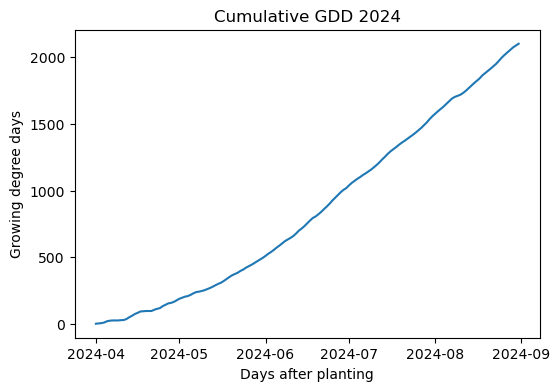

In [11]:
# Create figure
plt.figure(figsize=(6,4))

plt.plot(df['timestamp'], df['gdd_cum'])
plt.title('Cumulative GDD 2024')
plt.xlabel('Days after planting')
plt.ylabel('Growing degree days')

plt.savefig('gdd_figure.jpg', dpi=300)

plt.show()


### Create custom function: Estimate runoff

In this example we will implement the curve number method to estimate the amount of daily runoff.

##### Step 1: Create the function

In [12]:
def compute_runoff(P, CN):
    """Curve number method

    Inputs:
        P = Daily precipitation (mm)
        CN = Curve number

    Returns:
        Q = Daily runoff (mm)
    """
    
    # Maximum soil moisture retention after runoff begins
    S = 25400/CN - 254

    # Initial abstraction (Ia). Rainfall before runoff starts to occur.
    Ia = S * 0.2

    # Calculate runoff
    if P <= Ia:
        Q = 0.0
    else:
        Q = (P - Ia)**2 / (P - Ia + S)
    
    return Q


##### Step 2:  Call the function

In [17]:
# Call the function for a single precipitation value
CN = 80
compute_runoff(75, CN)

30.852861685214624

In [18]:
# Call the function for all precipitation values in our weather dataset and add a new runoff column to the Dataframe

# More efficient solution
#df['runoff'] = df.apply(lambda x: compute_runoff(x['rainfall'], 80), axis=1)


# Compute runoff for each day (not the most efficient, but this version is easier to understand)
runoff = [] # Create empty list that we will populate in each iteration with the results of the function
for k,row in df.iterrows():
    runoff.append( compute_runoff(row['rainfall'], CN) )

# Add list with all the runoff values as a new column to our existing Dataframe
df['runoff'] = runoff
df.head()


,timestamp,rainfall,eto_grass,eto_alfalfa,tmax,tmin,srad,tavg,gdd,gdd_cum,runoff
0,2024-04-01,0.0,2.87,4.14,17.7,4.0,12.9,10.85,2.85,2.85,0.0
1,2024-04-02,0.0,4.22,6.04,17.8,3.4,24.9,10.60,2.60,5.45,0.0
2,2024-04-03,0.0,3.85,5.07,20.3,-0.5,25.6,9.90,1.90,7.35,0.0
3,2024-04-04,0.0,4.38,5.88,24.3,0.8,26.0,12.55,4.55,11.90,0.0
4,2024-04-05,0.0,6.60,9.95,29.8,5.4,21.5,17.60,9.60,21.50,0.0


### Create a meteogram

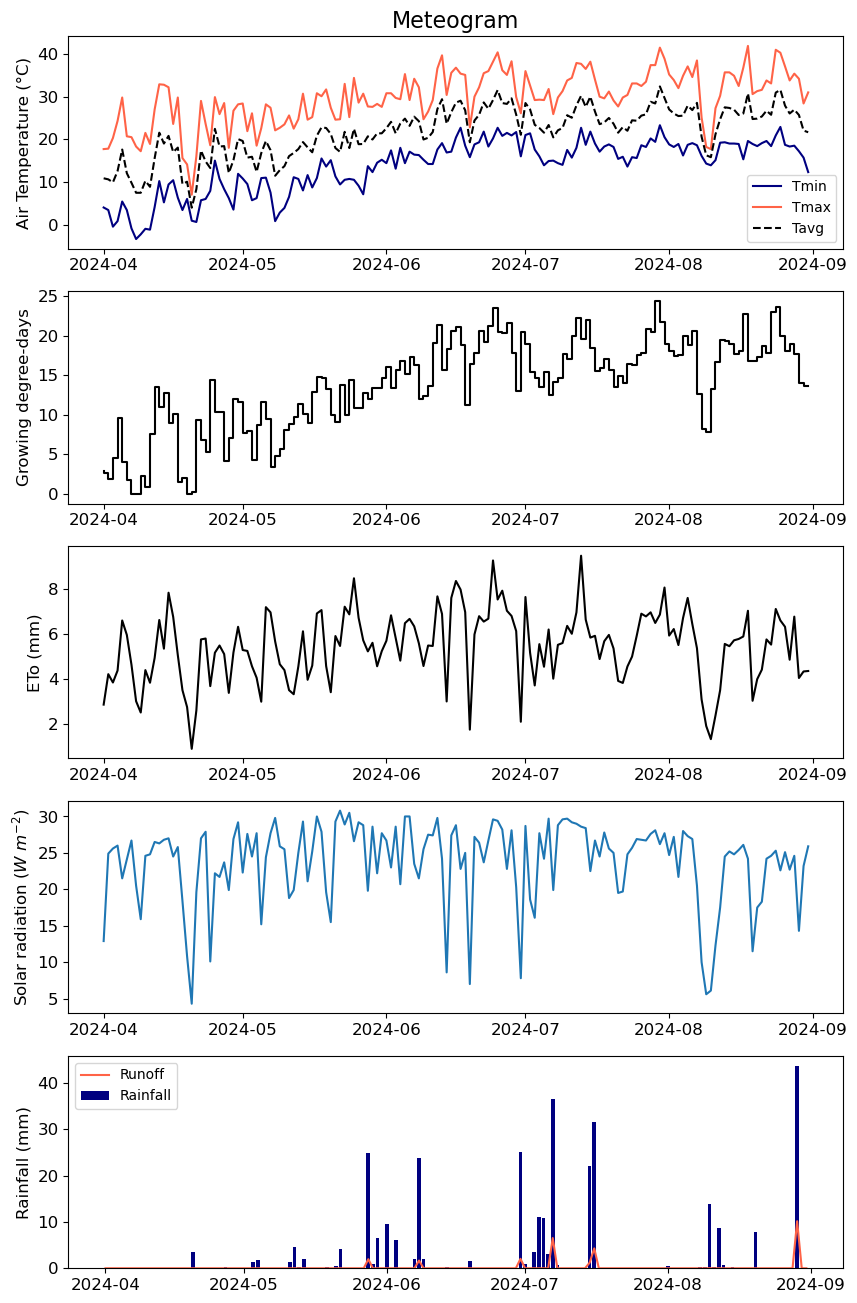

In [19]:
# Define fontsize
font_size = 12

# Create plot
plt.figure(figsize=(10,16))

# Air temperature
plt.subplot(5,1,1)
plt.title('Meteogram', size=16)
plt.plot(df['timestamp'], df['tmin'], color='navy', label='Tmin')
plt.plot(df['timestamp'], df['tmax'], color='tomato', label='Tmax')
plt.plot(df['timestamp'], df['tavg'], color='k', linestyle='--', label='Tavg')
plt.ylabel('Air Temperature (°C)', size=font_size)
plt.xticks(size=font_size)
plt.yticks(size=font_size)
plt.legend()

# Growing degree days
plt.subplot(5,1,2)
plt.step(df['timestamp'], df['gdd'], color='k')
plt.ylabel('Growing degree-days', size=font_size)
plt.xticks(size=font_size)
plt.yticks(size=font_size)

# Reference ET
plt.subplot(5,1,3)
plt.plot(df['timestamp'], df['eto_grass'], '-k')
plt.ylabel('ETo (mm)', size=font_size)
plt.xticks(size=font_size)
plt.yticks(size=font_size)

# Solar radiation
plt.subplot(5,1,4)
plt.plot(df['timestamp'], df['srad'])
plt.ylabel(r'Solar radiation ($W \ m^{-2}$)', size=font_size)
plt.xticks(size=font_size)
plt.yticks(size=font_size)

# Precipitation
plt.subplot(5,1,5)
plt.bar(df['timestamp'], df['rainfall'], color='navy', label='Rainfall')
plt.plot(df['timestamp'], df['runoff'], color='tomato', label='Runoff')
plt.ylabel('Rainfall (mm)', size=font_size)
plt.xticks(size=font_size)
plt.yticks(size=font_size)
plt.legend()

plt.subplots_adjust(hspace=0.2) # for space between columns wspace=0)

#plt.savefig('meteogram.svg', format='svg')
plt.show()